In [1]:
using Pkg
Pkg.activate("../")

"/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/Project.toml"

In [2]:
using FinNetValu
using ForwardDiff
using Distributions
using LinearAlgebra
using DataFrames
using SparseArrays
using Plots

┌ Info: Recompiling stale cache file /Users/wolfgang/.julia/compiled/v1.0/FinNetValu/88Ew8.ji for FinNetValu [2b4a169e-d971-11e8-348f-a5a54fd349b0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/wolfgang/.julia/compiled/v1.0/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /Users/wolfgang/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


# Some examples of network valuations

## Replicate fig. 2 (left panel) of Barucca et al.

Here, we illustrate how the network valuation models can be used.

First, look at the documentation for the EisenbergNoeModel

In [3]:
?EisenbergNoeModel

search: EisenbergNoeModel



```
EisenbergNoeModel(Lᵉ, L)
```

Creates an instance of the NEVAModel with valuation functions

$$
\begin{align}
\mathbb{V}^e_i(E_i) &= 1 \quad \forall i \\
\mathbb{V}_{ij}(E_j) &= \unicode{x1D7D9}_{E_j \geq 0} + \left(\frac{E_j + \bar{p}_j}{\bar{p}_j}\right)^+ \unicode{x1D7D9}_{E_j < 0} \quad \forall i, j
\end{align}
$$

where $\bar{p}_j = \sum_k L_{jk}$.

This valuation was shown to correspond to the model by Eisenberg & Noe.


Set the parameters as in the paper and create all models.

TODO: Implement the ex-ante Eisenberg & Noe model

In [4]:
Lᵉ = [9., 4., 2.]
A = [0 0.5 0;
     0 0 0.5;
     0.5 0 0]
Aᵉ = [10., 5., 3.]

models = [EisenbergNoeModel(Lᵉ, A'),
          FurfineModel(Lᵉ, A', 0.0),
          LinearDebtRankModel(Lᵉ, A')]

3-element Array{NEVAModel,1}:
 Eisenberg & Noe model with N = 3 firms. 
 Furfine model with N = 3 firms.         
 Linear Debt Rank model with N = 3 firms.

Then shock each model by decreasing the external asset value by a factor $\alpha$ and compute the impact on the equity value as in the paper, i.e.
$$
    \frac{\sum_i {\Delta}E_i - {\Delta}A^e_i}{\sum_{ij} A_{ij}}
$$
where ${\Delta}A^e = \alpha A^e$.

In [5]:
function runshock(model, Aᵉ, α)
    E₀ = fixvalue(model, Aᵉ)
    ΔAᵉ = α .* Aᵉ
    ΔE  = E₀ .- fixvalue(model, Aᵉ .- ΔAᵉ)
    sum(ΔE .- ΔAᵉ) / sum(model.A)
end

runshock (generic function with 1 method)

In [6]:
αs = range(0, length = 101, stop = 0.6)
shocks = collect(runshock(model, Aᵉ, α)
                 for α in αs,
                     model in models)

101×3 Array{Float64,2}:
  0.0           0.0          0.0        
  3.60822e-16   3.60822e-16  9.03037e-9 
 -7.58652e-16  -7.58652e-16  1.03422e-9 
 -3.88578e-16  -3.88578e-16  5.11193e-10
  2.59052e-16   2.59052e-16  8.06174e-9 
  6.29126e-16   6.29126e-16  7.78693e-9 
 -4.81097e-16  -4.81097e-16  5.28638e-9 
 -1.85037e-16  -1.85037e-16  9.10972e-9 
  5.18104e-16   5.18104e-16  1.48175e-8 
 -9.4369e-16   -9.4369e-16   8.8836e-9  
 -2.22045e-16  -2.22045e-16  7.89447e-9 
  7.40149e-17   7.40149e-17  3.30149e-8 
  8.14164e-16   8.14164e-16  2.04415e-7 
  ⋮                                     
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0        
  1.0           1.0          1.0 

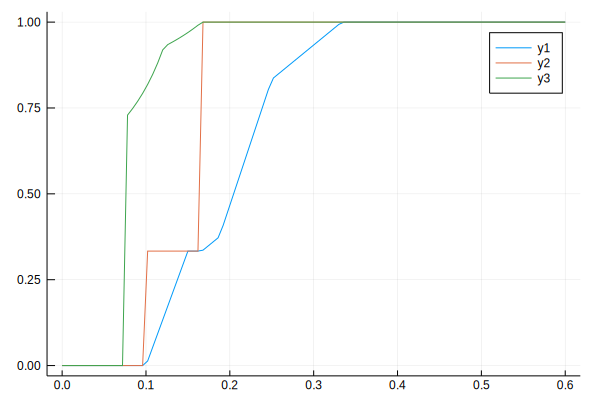

In [7]:
plot(αs, shocks)

## Replicate Greeks figures from our paper

Start with $\Delta$, i.e. compute the risk-neutral expectation over the gradient wrt $a_0$. As in the paper, we show the mean impact of an asset price shock for each bank, separately for equity and debt.

In [8]:
function delta(net, a₀, θ, Z)
    @assert length(a₀) == numfirms(net)
    A = Aτ(a₀, θ, Z)
    x = fixvalue(net, A;
                 method = :anderson, m = 5)
    dVdA = fixjacobian(net, A, x)
    dAda₀ = ForwardDiff.jacobian(a -> Aτ(a, θ, Z), a₀)
    ## Compute Δ as in eq. ???
    dVda₀ = discount(θ) * dVdA * dAda₀

    N = numfirms(net)
    deltaEq = sum(equityview(net, dVda₀)) / N
    deltaDb = sum(debtview(net, dVda₀)) / N
    [deltaEq, deltaDb, deltaEq + deltaDb]
end

delta (generic function with 1 method)

In [9]:
θ = BlackScholesParams(0.0, 1.0, 0.4)
N = 60
k = 3.0
wᵈ = 0.6;

Create a random Erdos-Renyi network of debt cross-holdings for the above parameters.

In [10]:
function randnet(N, k, wᵈ)
    p = k / (N - 1)
    XOSModel(spzeros(N, N),
             rescale(erdosrenyi(N, p), wᵈ),
             I, ones(N))
end

nextnet = calm(() -> randnet(N, k, wᵈ), 100);

Run over a range of initial asset prices and compute $\Delta$ in each case.

Note that calming the network creation function achieves that each network is used 100 times during the Monte-Carlo expectation.

In [11]:
a₀ = range(0, length = 31, stop = 2.0)
@time Δ = collect(expectation(z -> delta(nextnet(), a * ones(N), θ, z),
                              MonteCarloSampler(MvNormal(N, 1.0)),
                              2500)
                  for a in a₀);

 90.382153 seconds (103.90 M allocations: 122.082 GiB, 17.81% gc time)


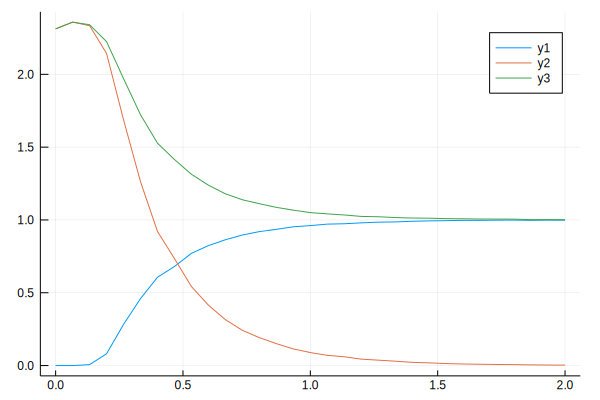

In [12]:
plot(a₀, transpose(hcat(Δ...)))

## Testing Barabasi Albert Graph

In [3]:
FinNetValu.barabasialbert(6,2)

6×6 SparseMatrixCSC{Float64,Int64} with 18 stored entries:
  [2, 1]  =  1.0
  [3, 1]  =  1.0
  [4, 1]  =  1.0
  [5, 1]  =  1.0
  [1, 2]  =  1.0
  [3, 2]  =  1.0
  [4, 2]  =  1.0
  [5, 2]  =  1.0
  [6, 2]  =  1.0
  [1, 3]  =  1.0
  [2, 3]  =  1.0
  [1, 4]  =  1.0
  [2, 4]  =  1.0
  [1, 5]  =  1.0
  [2, 5]  =  1.0
  [6, 5]  =  1.0
  [2, 6]  =  1.0
  [5, 6]  =  1.0